# Detecting Topic Merges and Splits in Dynamic Political Conversations

Cláudia Oliveira 

Supervisor - Prof. Dr. Álvaro Figueira

Faculty of Science, University of Porto

Import packages

In [1]:
import pandas as pd
import re
import string
import emoji
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
import sys
from functions import *
from collections import Counter
nlp_ner = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
from datetime import timedelta
from multiprocessing import Pool, cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from multiprocessing import Pool, cpu_count
from sklearn.metrics.pairwise import cosine_similarity

### Part 1 - Process Data

Removing the tweets that aren't in english and concatenate the text from the tweet with the hashtags and urls and clean 

In [ ]:
tweets = pd.read_csv("datasets/tweets.csv", encoding="utf-8", low_memory=False)

tweets = tweets[tweets['language'] == 'en'].copy()

tweets['text_combined'] = parallel_apply(tweets, clean_tweet_row)

Eliminate empty lanes

In [ ]:
tweets = tweets[tweets['text_combined'].str.strip() != ""].copy()

In [ ]:
tweets['text_combined'].head(10)

0                                   tweet private like
1                         let go repyvetteclarke unity
2                                 illegal realtomhoman
3    clear charlie kirk man believe civil right act...
4    scourge gun violence political violence must e...
5    go assume try reply burp tweet ether instead s...
6    nyer know andrew cuomo back trump orbit lose p...
7    chriscuomo deepfake dude please use critical t...
8    force famine million people gaza include one f...
9                                   let go votejgr get
Name: text_combined, dtype: object

Check which are the most common used entities so we can try to normalize them 

In [ ]:
all_entities = []

for doc in nlp_ner.pipe(tweets['text_combined'], batch_size=500, n_process=4):
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG"]:
            all_entities.append(ent.text)

entity_counts = Counter(all_entities)
top_entities = entity_counts.most_common(200)

for ent, count in top_entities:
    print(f"{ent}: {count}")

congress: 19762
senate: 11075
medicaid: 8993
gop: 3764
donald trump: 3733
house: 3135
hamas: 3030
white house: 2998
fema: 2953
medicare: 2718
fbi: 2334
supreme court: 2021
irs: 1829
biden harris: 1667
putin: 1419
epa: 1308
charlie kirk: 1183
cnn: 1117
ccp: 1057
sec: 1042
un: 962
joe biden: 845
nih: 841
god: 818
johnson: 764
npr: 763
kamala harris: 751
gutte: 723
pentagon: 587
nasa: 581
nato: 581
laken riley act: 551
capitol hill: 543
capitol: 520
jimmy carter: 502
fda: 486
hamadeh: 473
hezbollah: 471
honor join: 465
healthcare: 449
fed: 435
mike: 414
pbs: 411
carter: 408
fcc: 356
reagan: 344
laken riley: 340
navy: 331
trump: 329
msnbc: 328
treasury: 328
pete hegseth: 311
petehegseth: 294
biden: 292
tim: 290
biden harris administration: 284
nebraska: 278
charlie: 275
mike johnson: 271
cnbc: 268
john lewis: 266
elon musk: 261
cdc: 260
secrollin: 259
house news documentsingle: 257
biden administration: 251
kash patel: 246
cia: 243
kim: 243
intel: 237
donald j: 237
senate news: 234
trumps:

In [ ]:
entity_dict = {
    # Those who have to change
    "capitol hill": "capitol",
    "fbi": "federal bureau of investigation",
    "cia": "central intelligence agency",
    "epa": "environmental protection agency",
    "fda": "food and drug administration",
    "fema": "federal emergency management agency",
    "fcc": "federal communications commission",
    "irs": "internal revenue service",
    "sec": "securities and exchange commission",
    "fed": "federal reserve",
    "hud": "department of housing and urban development",
    "cdc": "centers for disease control and prevention",
    "nih": "national institutes of health",
    "medicaid medicare": "medicare and medicaid",
    "medicare medicaid": "medicare and medicaid",
    "aca": "affordable care act",
    "ndaa": "national defense authorization act",
    "un": "united nations",
    "biden": "joe biden",
    "joe": "joe biden",
    "biden harris": "joe biden kamala harris",
    "harris": "kamala harris",
    "trump": "donald trump",
    "trumps": "donald trump",
    "putin": "vladimir putin",
    "reagan": "ronald reagan",
    "carter": "jimmy carter",
    "rubio": "marco rubio",
    "mike": "mike johnson",
    "charlie": "charlie kirk",
    "petehegseth": "pete hegseth",
    "johnson": "mike johnson",
    "kennedy": "john f kennedy", 
    "npr pbs": "npr and pbs",
    "wsj wsj": "wall street journal",
    "house news documentsingle": "house news",
    "morningsmaria": "mornings with maria",
    "ccp": "chinese communist party",
    "netanyahu": "benjamin netanyahu",
    "zelensky": "volodymyr zelensky",
    "housedemocrat": "democratic party",
    "gop": "republican party",
    "united state": "united states of america",
    "united states": "united states of america",
    
    # Those remaining the same
    "congress": "congress",
    "senate": "senate",
    "medicaid": "medicaid",
    "house": "house",
    "hamas": "hamas",
    "white house": "white house",
    "healthcare": "healthcare",
    "capitol": "capitol",
    "laken riley act": "laken riley act",
    "laken riley": "laken riley",
    "elon musk": "elon musk",
    "pope francis": "pope francis",
    "harvard": "harvard",
    "matt": "matt",
    "linda mcmahon": "linda mcmahon",
    "bill house": "bill house",
    "cbs": "cbs",
    "town hall": "town hall",
    "jeffrey epstein": "jeffrey epstein",
    "nj": "nj",
    "chuck schumer": "chuck schumer",
    "miller": "miller",
    "ec": "ec",
    "arkansa": "arkansa",
    "trump agenda": "trump agenda",
    "chris": "chris",
    "nebraskan": "nebraskan",
    "trump house": "trump house",
    "big news": "big news",
    "army": "army",
    "senate news": "senate news",
    "senate news press": "senate news press",
    "please join": "please join",
    "kash patel": "kash patel",
    "kim": "kim",
    "donald j": "donald j",
    "hurricane milton": "hurricane milton",
    "buff": "buff",
    "lincoln": "lincoln",
    "rosh hashanah": "rosh hashanah",
    "taylor": "taylor",
    "ga": "ga",
    "abc": "abc",
    "taliban": "taliban",
    "coast guard": "coast guard",
    "marine corps": "marine corps",
    "justice department": "justice department",
    "american energy": "american energy",
    "fox news": "fox news",
    "paul": "paul",
    "clinton": "clinton",
    "army corps": "army corps",
    "dreamer": "dreamer",
    "kremlin": "kremlin",
    "gutte medicaid": "gutte medicaid",
    "gerry connolly": "gerry connolly",
    "rick scott": "rick scott",
    "social security": "social security",
    "proud join": "proud join",
    "jd vance": "jd vance",
    "austin": "austin",
    "melissa hortman": "melissa hortman",
    "solidarity": "solidarity",
    "maxwell": "maxwell",
    "george washington": "george washington",
    "raul gonzalez": "raul gonzalez",
    "john hoffman": "john hoffman",
    "john": "john",
    "gold star": "gold star",
    "tom homan": "tom homan",
    "wwii": "wwii",
    "mexico canada": "mexico canada",
    "media center press": "media center press",
    "icymi join": "icymi join",
    "pell": "pell",
    "social security administration": "social security administration",
    "amtrak": "amtrak",
    "bipartisan bill": "bipartisan bill",
    "abbey gate": "abbey gate",
    "kilmar": "kilmar",
    "national police week": "national police week",
    "david": "david",
    "williams": "williams",
    "ivf": "ivf",
    "mar lago": "mar lago",
    "catholic church": "catholic church",
    "hawley": "hawley",
    "countdowntosrd countdowntosrd": "countdowntosrd countdowntosrd",
    "dr martin luther king jr": "dr martin luther king jr",
    "michael": "michael",
    "thompson": "thompson",
    "smithsonian": "smithsonian",
    "davis": "davis",
    "markup": "markup",
    "jesus": "jesus",
    "al": "al",
    "chag": "chag",
    "house armed services committee": "house armed services committee",
    "george floyd": "george floyd",
    "senate judiciary committee": "senate judiciary committee",
    "warren": "warren",
    "trump administration": "trump administration",
    "medicare": "medicare",
    "pentagon": "pentagon",
    "nasa": "nasa",
    "nato": "nato",
    "hamadeh": "hamadeh",
    "hezbollah": "hezbollah",
    "honor join": "honor join",
    "navy": "navy",
    "tim": "tim",
    "nebraska": "nebraska",
    "cnbc": "cnbc",
    "john lewis": "john lewis",
    "secrollin": "secrollin",
    "intel": "intel",
    "senate newsroom": "senate newsroom",
    "katie britt": "katie britt",
    "leo xiv": "leo xiv",
    "mike johnson": "mike johnson",
    "biden administration": "biden administration",
    "joe biden kamala harris": "joe biden kamala harris",
    "bill senate": "bill senate",
    "media press": "media press",
    "gutte": "gutte",
    "jimmy kimmel": "jimmy kimmel",
    "joe biden": "joe biden",
    "god": "god",
    "npr": "npr",
    "kamala harris": "kamala harris",
    "pete hegseth": "pete hegseth",
    "biden harris administration": "biden harris administration",
    "chinese communist party": "chinese communist party",
    "vladimir putin": "vladimir putin",
    "kilmar abrego garcia": "kilmar abrego garcia",
    "ronald reagan": "ronald reagan",
    "social security medicare": "social security medicare",
    "marco rubio": "marco rubio",
    "repjeffrie": "repjeffrie",
    "jack smith": "jack smith",
    "ford": "ford",
    "job corps": "job corps",
    "god bless america": "god bless america",
    "supreme court": "supreme court",
    "cnn": "cnn", 
    "treasury": "treasury",
    "msnbc": "msnbc",
    "pbs": "pbs",
    "mahmoud khalil": "mahmoud khalil"
}

In [ ]:
print(len(entity_dict))

193


There are 193 because I only chose people and organizations

In [ ]:
tweets['text_normalized'] = tweets['text_combined'].apply(
    lambda x: normalize_entities(x, entity_dict, list(entity_dict.keys()))
)

In [ ]:
tweets['text_normalized'].head(10)

0                                   tweet private like
1                         let go repyvetteclarke unity
2                                 illegal realtomhoman
3    clear charlie kirk kirk man believe civil righ...
4    scourge gun violence political violence must e...
5    go assume try reply burp tweet ether instead s...
6    nyer know andrew cuomo back donald trump orbit...
7    chriscuomo deepfake dude please use critical t...
8    force famine million people gaza include one f...
9                                   let go votejgr get
Name: text_normalized, dtype: object

Saving the cleaned dataset

In [ ]:
tweets.to_csv("datasets/cleanedtweets.csv", index=False)

Top Features using TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

tfidf_matrix = vectorizer.fit_transform(tweets['text_normalized'])

tfidf_scores = tfidf_matrix.mean(axis=0).A1
terms = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame({'term': terms, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False)

top50 = tfidf_df.head(50)
print(top50)

             term     score
1338       donald  0.024832
4616        trump  0.022714
4943         work  0.016311
3426    president  0.015556
2690         make  0.014196
1670       family  0.013747
181      american  0.013649
450          bill  0.013354
3277       people  0.012598
1102          day  0.012539
861     community  0.012356
4517        today  0.012353
4457        thank  0.012034
179       america  0.011911
2151        house  0.011668
3102          one  0.011368
4980         year  0.011223
1896          get  0.010916
1065          cut  0.010698
2960         need  0.010675
1947        great  0.010462
48            act  0.010449
4344      support  0.010378
182     americans  0.010227
1696      federal  0.010114
1716        fight  0.010037
4404          tax  0.009667
622          care  0.009400
3502      protect  0.009392
2979          new  0.009358
2067         help  0.009312
2044       health  0.009188
2467         keep  0.009116
909      congress  0.009009
4505         time  0

Word Cloud

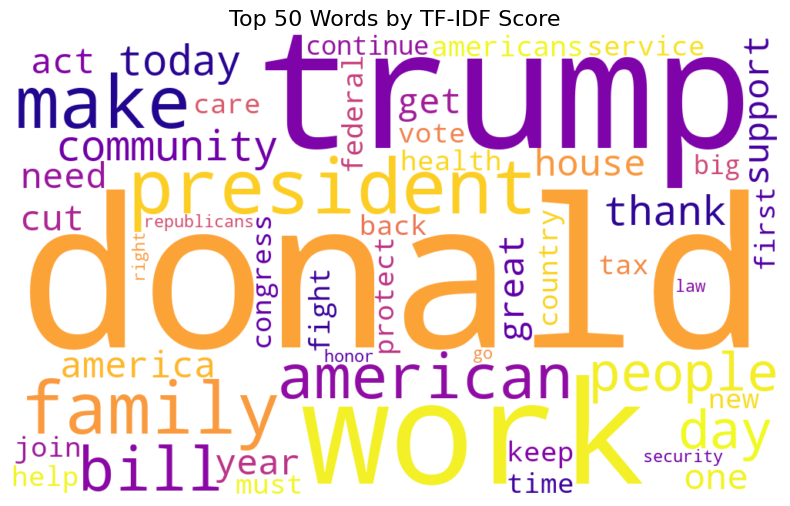

In [ ]:
word_scores = dict(zip(top50['term'], top50['score']))

wc = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='plasma'
).generate_from_frequencies(word_scores)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Top 50 Words by TF-IDF Score", fontsize=16)
plt.show()

### Part 2 - Modelling

In [ ]:
tweets = pd.read_csv("datasets/cleanedtweets.csv", encoding="utf-8", low_memory=False)

Only keeping the interesting columns for the objective of this work

In [ ]:
tweets = tweets[['created_at', 'text_normalized']].copy()
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets = tweets.sort_values('created_at')

Tokenizing

In [ ]:
tweets["tokens"] = tweets["text_normalized"].apply(spacy_tokenize)
tweets["tokens"].head(5)

34009     [congratulation, lieutenant, crapo, hard, earn...
98100     [travel, abroad, soon, travel, tip, easily, re...
88168     [thank, white, house, office, gun, violence, p...
8114      [usda, require, collect, datum, foreign, purch...
215083    [donald, trump, admin, project, peace, strengt...
Name: tokens, dtype: object

Defining the sliding window parameters

In [ ]:
start_date = pd.Timestamp('2024-09-26')
end_date   = pd.Timestamp('2025-09-24')
window_size = timedelta(days=7)
step_size   = timedelta(days=1)

#### LDA

In [ ]:
window_starts = []
current_start = start_date
while current_start + window_size <= end_date:
    window_starts.append(current_start)
    current_start += step_size
    
results = []
prev_topics_vecs = None
for start in window_starts:
    res = process_window(start, tweets, window_size, prev_topics_vecs)
    if res is not None:
        prev_topics_vecs = res['topics_vecs']
        res.pop('topics_vecs')  # remove before saving
        results.append(res)

Saving Results from LDA

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("datasets/lda_results.csv", index=False)

In [ ]:
df_results

,start_date,end_date,num_docs,coherence,perplexity,diversity,stability,topics
0,2024-09-26,2024-10-03,5649,0.450598,-7.975713,1.00,NaN,"[0.019*""helene"" | 0.015*""hurricane"" | 0.013*""h..."
1,2024-09-27,2024-10-04,5603,0.529196,-7.923076,1.00,0.154462,"[0.017*""helene"" | 0.015*""federal"" | 0.015*""hur..."
2,2024-09-28,2024-10-05,5573,0.480664,-7.943000,1.00,0.129123,"[0.016*""federal"" | 0.015*""helene"" | 0.014*""hur..."
3,2024-09-29,2024-10-06,5525,0.511180,-7.931665,1.00,0.161952,"[0.019*""federal"" | 0.016*""helene"" | 0.015*""hur..."
4,2024-09-30,2024-10-07,5467,0.550427,-7.938927,1.00,0.170784,"[0.019*""federal"" | 0.015*""hurricane"" | 0.015*""..."
...,...,...,...,...,...,...,...,...
352,2025-09-13,2025-09-20,7765,0.443547,-7.891474,1.00,0.168039,"[0.037*""kirk"" | 0.019*""charlie"" | 0.011*""honor..."
353,2025-09-14,2025-09-21,7819,0.466838,-7.870292,0.96,0.161426,"[0.032*""kirk"" | 0.016*""charlie"" | 0.014*""honor..."
354,2025-09-15,2025-09-22,7832,0.486127,-7.875749,1.00,0.161860,"[0.039*""kirk"" | 0.020*""charlie"" | 0.015*""honor..."
355,2025-09-16,2025-09-23,7884,0.465396,-7.868928,0.88,0.171968,"[0.035*""kirk"" | 0.017*""charlie"" | 0.016*""honor..."
